# Simple inversion
Here we will walkthrough a very simple gravity inversion using synthetic data. The goal of the inversion is to recover the geometry of a layer. In this case, the layer is simply the surface of the Earth, which is represented by the density contrast between air and rock.

## Import packages
We need to import the *Invert4Geom* package, as well as a few others.

In [2]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import verde as vd
from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography grid, which represents the `true` Earth topography which we hope to recover during the inversion. The observed gravity will be the forward-calculated gravity effect of this topography.

Below we specify the spacing and region of the topography, choose a zref and density contrast to use to calculate the topography's gravity effect, and contaminate the gravity with some pseudo-random noise.

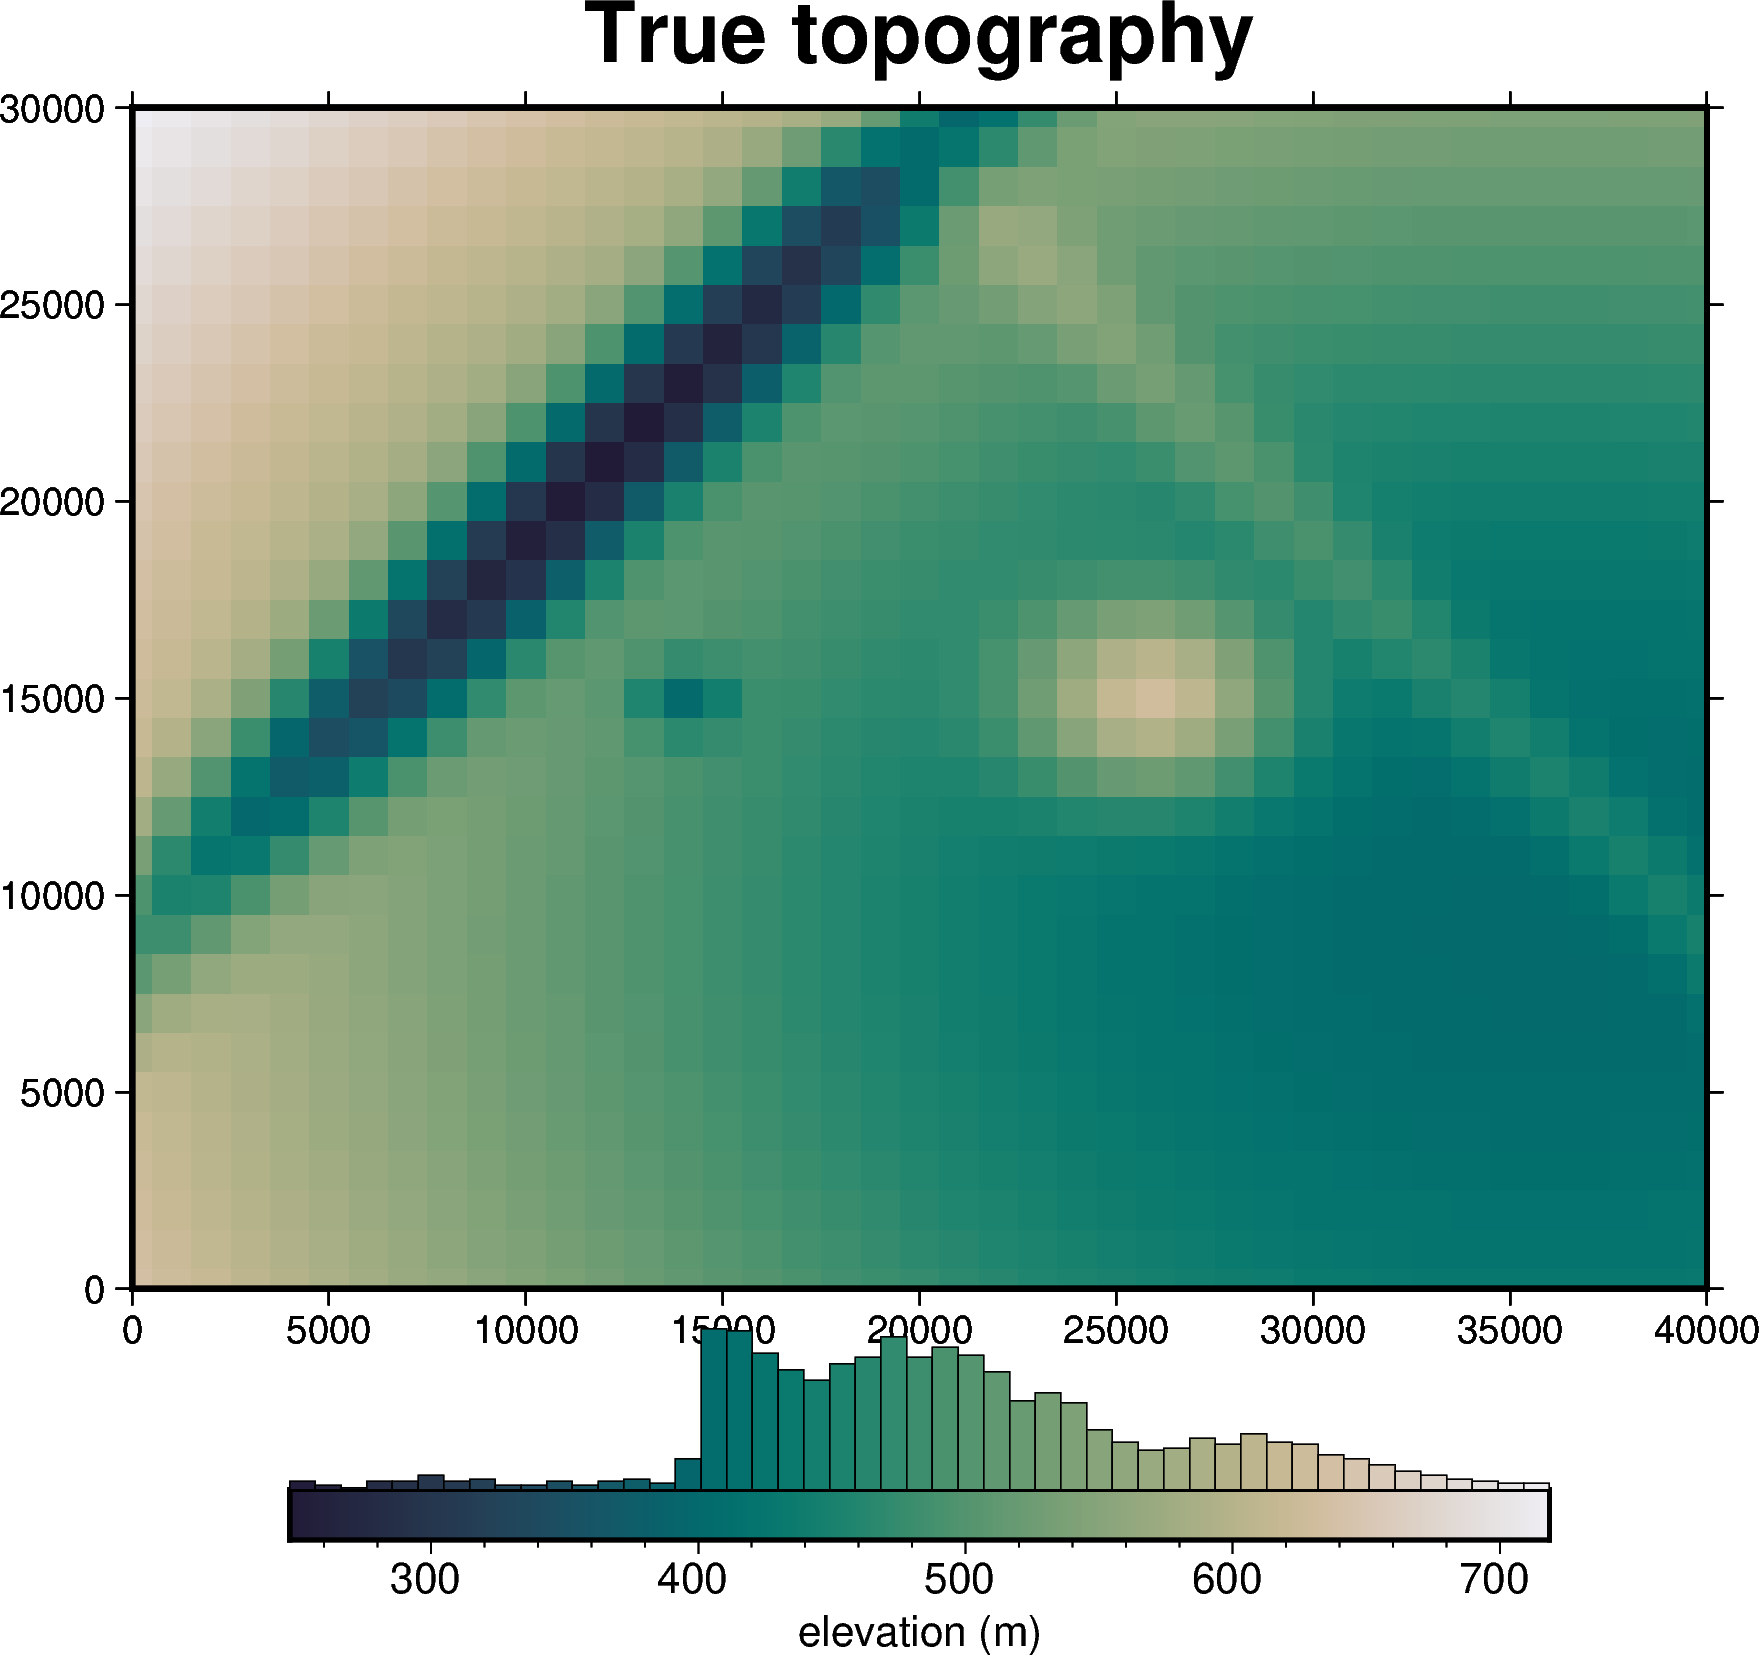

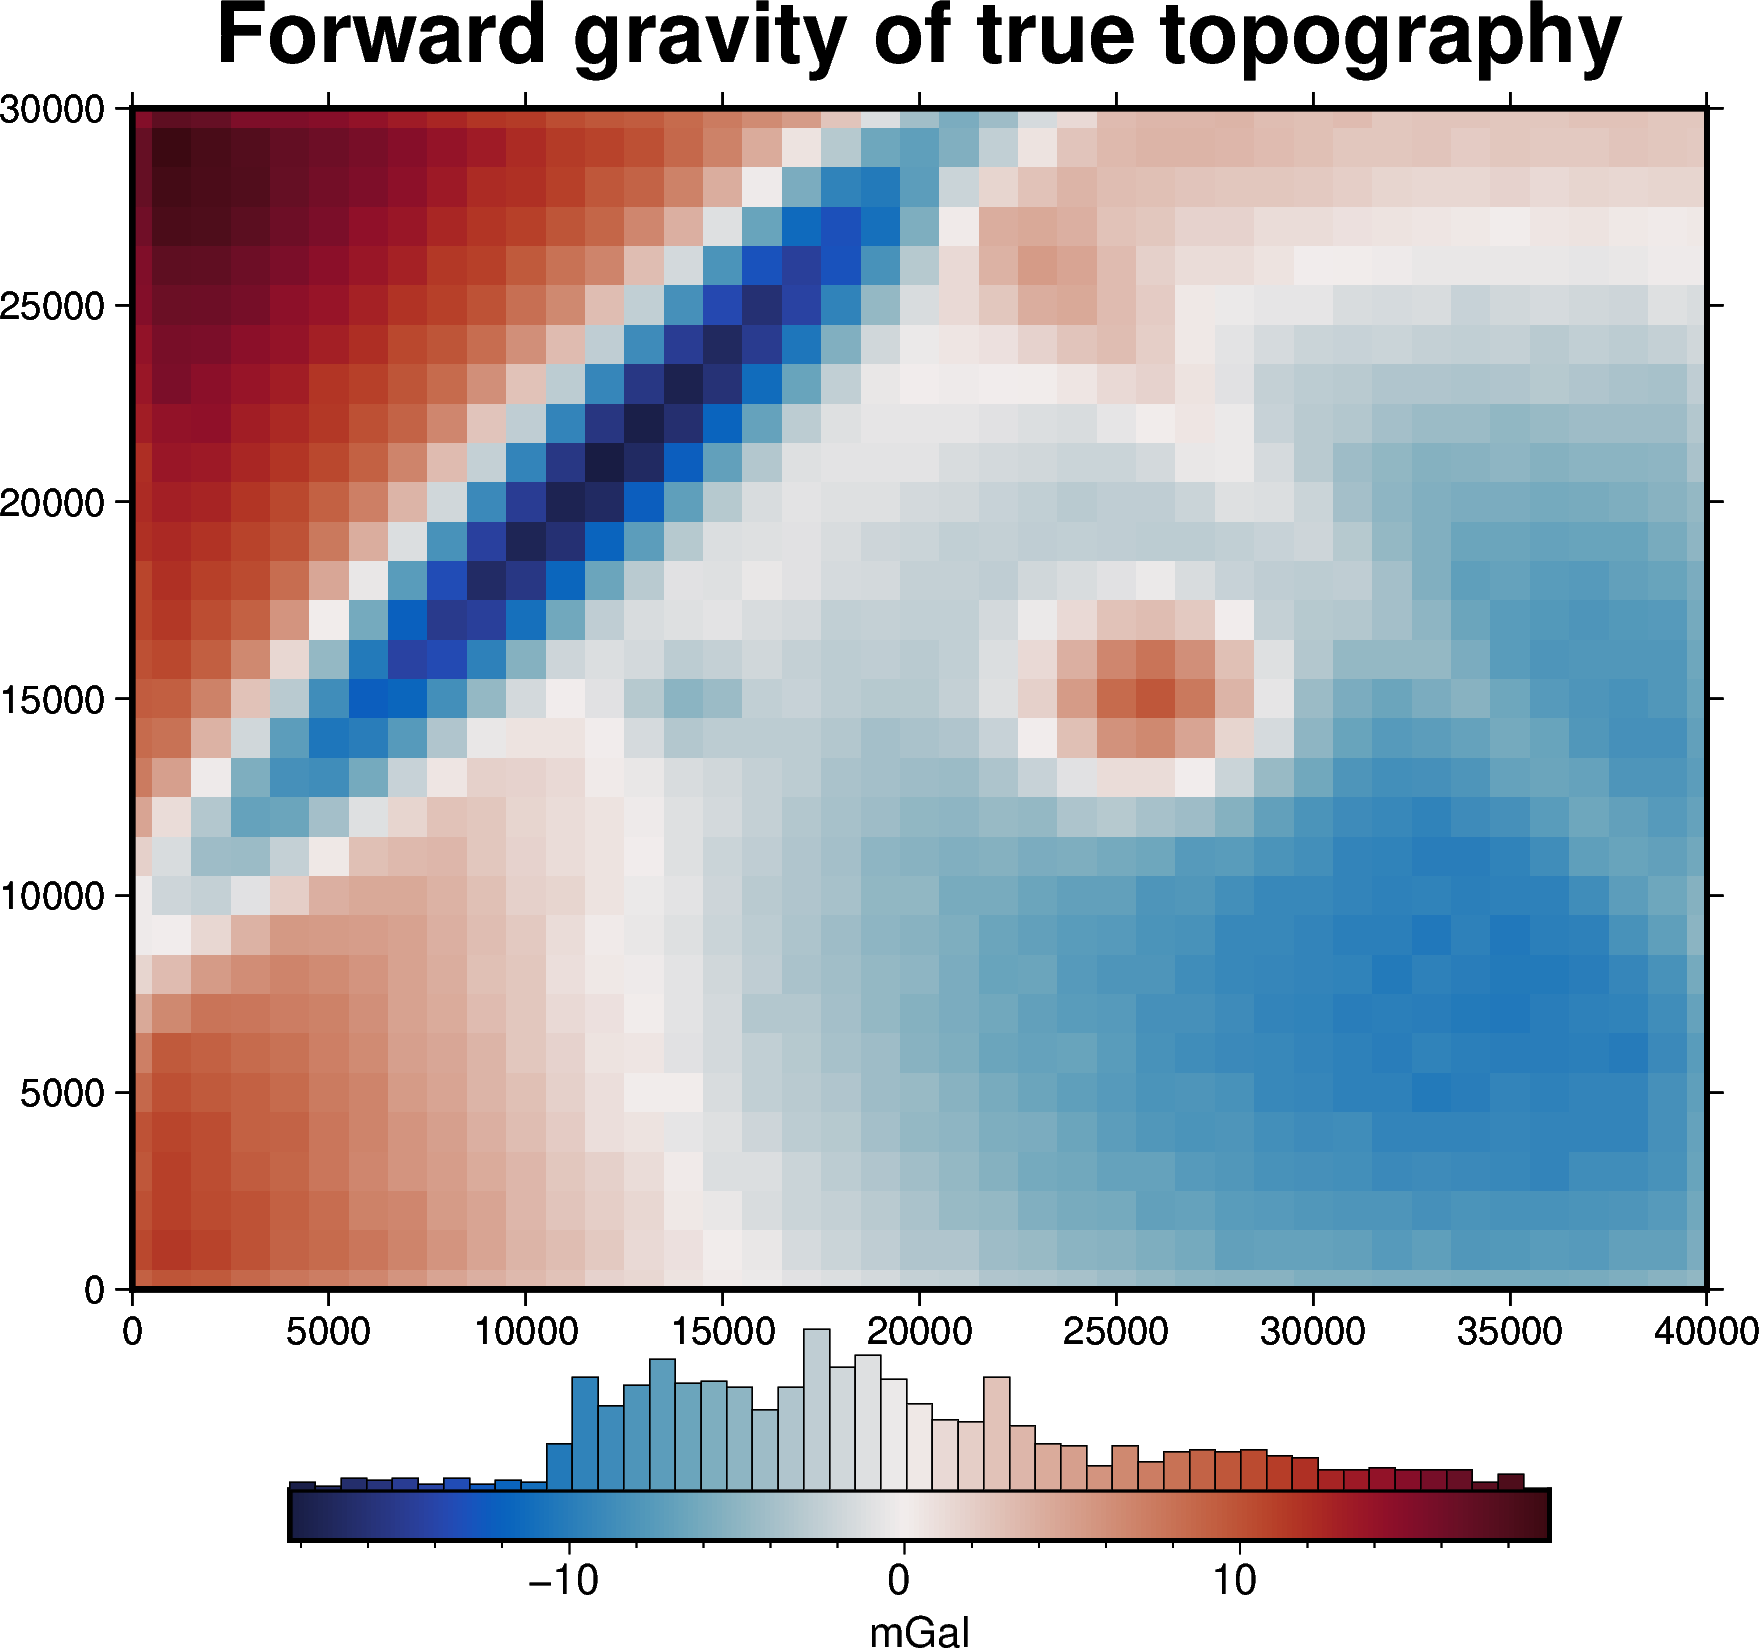

,northing,easting,upward,gravity_anomaly
count,1271.000000,1271.00000,1271.0,1271.000000
mean,15000.000000,20000.00000,1000.0,-0.926892
std,8947.792584,11836.81698,0.0,7.166447
min,0.000000,0.00000,1000.0,-18.336010
25%,7000.000000,10000.00000,1000.0,-6.357548
50%,15000.000000,20000.00000,1000.0,-1.915659
75%,23000.000000,30000.00000,1000.0,2.934034
max,30000.000000,40000.00000,1000.0,19.220326


In [ ]:
true_topography, _, _, observed_gravity = invert4geom.load_synthetic_model(
    spacing=1000,
    region=(0, 40000, 0, 30000),
    density_contrast=2670 - 1,  # density contrast between rock and air
    zref=500,
    gravity_noise=0.2,
    plot_gravity=True,
    plot_topography=True,
)

## Initialize the gravity data class

We start by creating an instance of the class `inversion.GravData` to hold the gravity data, and some attributes: 
* `df`: a pandas dataframe of the gravity data  
* `ds`: a xarray dataset of the gravity data  
* `region`: the regional extent of the gravity data (x_min, x_max, y_min, y_max)  
* `spacing`: the spacing of the gridded gravity data  

In [ ]:
data = invert4geom.create_data(observed_gravity)
data

<xarray.Dataset> Size: 21kB
Dimensions:          (northing: 31, easting: 41)
Coordinates:
  * northing         (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting          (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    upward           (northing, easting) float64 10kB 1e+03 1e+03 ... 1e+03
    gravity_anomaly  (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)

## Create a starting topography grid
Here we assume we know nothing about the topography, so we create a flat grid with a value of 500 m.

In [5]:
# make a flat grid at 500 m
grid_coords = vd.grid_coordinates(
    spacing=1000,
    region=(0, 40000, 0, 30000),
)
starting_topography = vd.make_xarray_grid(
    grid_coords,
    data=np.ones_like(grid_coords[0]) * 500,
    data_names="upward",
)
starting_topography

<xarray.Dataset> Size: 11kB
Dimensions:   (northing: 31, easting: 41)
Coordinates:
  * easting   (easting) float64 328B 0.0 1e+03 2e+03 ... 3.8e+04 3.9e+04 4e+04
  * northing  (northing) float64 248B 0.0 1e+03 2e+03 ... 2.8e+04 2.9e+04 3e+04
Data variables:
    upward    (northing, easting) float64 10kB 500.0 500.0 500.0 ... 500.0 500.0

## Create a Model object
Next we create and instance of the class `invert4geom.create_model` which take the starting topography grid, and converted it into a layer of vertical adjacent prisms. These prisms are assigned densities based on the provided density contrast and reference level. See [the previous notebook](01_discretization) for how this works. The instance holds the prism layer, as well as attributes:  
* `prism_layer`: a xarray dataset of the prism layer  
* `region`: the regional extent of the prism layer (x_min, x_max, y_min, y_max)  
* `spacing`: the spacing of the prisms  
* `zref`: the reference level used to create the prisms  
* `density_contrast`: the density contrast (value or grid of values) used to create the prisms  

In [6]:
# initialize the Model object
model = invert4geom.create_model(
    zref=500,
    density_contrast=2670 - 1,
    starting_topography=starting_topography,
)
model

<xarray.Dataset> Size: 92kB
Dimensions:                (northing: 31, easting: 41)
Coordinates:
  * easting                (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
  * northing               (northing) float64 248B 0.0 1e+03 ... 2.9e+04 3e+04
    top                    (northing, easting) float64 10kB 500.0 ... 500.0
    bottom                 (northing, easting) float64 10kB 500.0 ... 500.0
Data variables:
    density                (northing, easting) int64 10kB 2669 2669 ... 2669
    thickness              (northing, easting) float64 10kB 0.0 0.0 ... 0.0 0.0
    starting_topography    (northing, easting) float64 10kB 500.0 ... 500.0
    topography             (northing, easting) float64 10kB 500.0 ... 500.0
    mask                   (northing, easting) float64 10kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
Attributes:
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    zref:              500
    density_contrast:  2669
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           1000.0

## Gravity misfit
Now we need to use this starting prism model to calculate the gravity misfit, which is the difference between the observed gravity and the gravity effect of this starting prism model. If this case, the starting model is flat, so it has no gravity effect.

To calculate the forward gravity effect of the starting model, use the GravData class method `starting_gravity()`


In [7]:
data.inv.starting_gravity(
    model,
    progressbar=True,
)
data

  0%|          | 0/1271 [00:00<?, ?it/s]

<xarray.Dataset> Size: 31kB
Dimensions:          (northing: 31, easting: 41)
Coordinates:
  * northing         (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting          (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    upward           (northing, easting) float64 10kB 1e+03 1e+03 ... 1e+03
    gravity_anomaly  (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
    forward_gravity  (northing, easting) float64 10kB -0.0 -0.0 ... -0.0 -0.0
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)

In many cases, we want to remove a regional signal from the misfit to isolate the residual signal. In this simple case, we assume there is no regional component to the misfit and set it to 0. The function below will subtract the column `starting_gravity` from `gravity_anomaly` to create `misfit`. The `reg` column (chosen here to be 0) is then subtracted from `misfit` to get `res`, the residual gravity misfit.

In [8]:
data.inv.regional_separation(
    method="constant",
    constant=0,
)
data

<xarray.Dataset> Size: 92kB
Dimensions:          (northing: 31, easting: 41)
Coordinates:
  * northing         (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting          (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    upward           (northing, easting) float64 10kB 1e+03 1e+03 ... 1e+03
    gravity_anomaly  (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
    forward_gravity  (northing, easting) float64 10kB -0.0 -0.0 ... -0.0 -0.0
    misfit           (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
    reg              (northing, easting) int64 10kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    res              (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
    starting_misfit  (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
    starting_reg     (northing, easting) int64 10kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    starting_res     (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)

We can plot all these anomalies with the GravData class method `plot_anomalies()`.

makecpt [ERROR]: Option T: min >= max
supplied min value is greater or equal to max value
Grid/points are a constant value, can't make a colorbar histogram!
makecpt [ERROR]: Option T: min >= max
supplied min value is greater or equal to max value
Grid/points are a constant value, can't make a colorbar histogram!


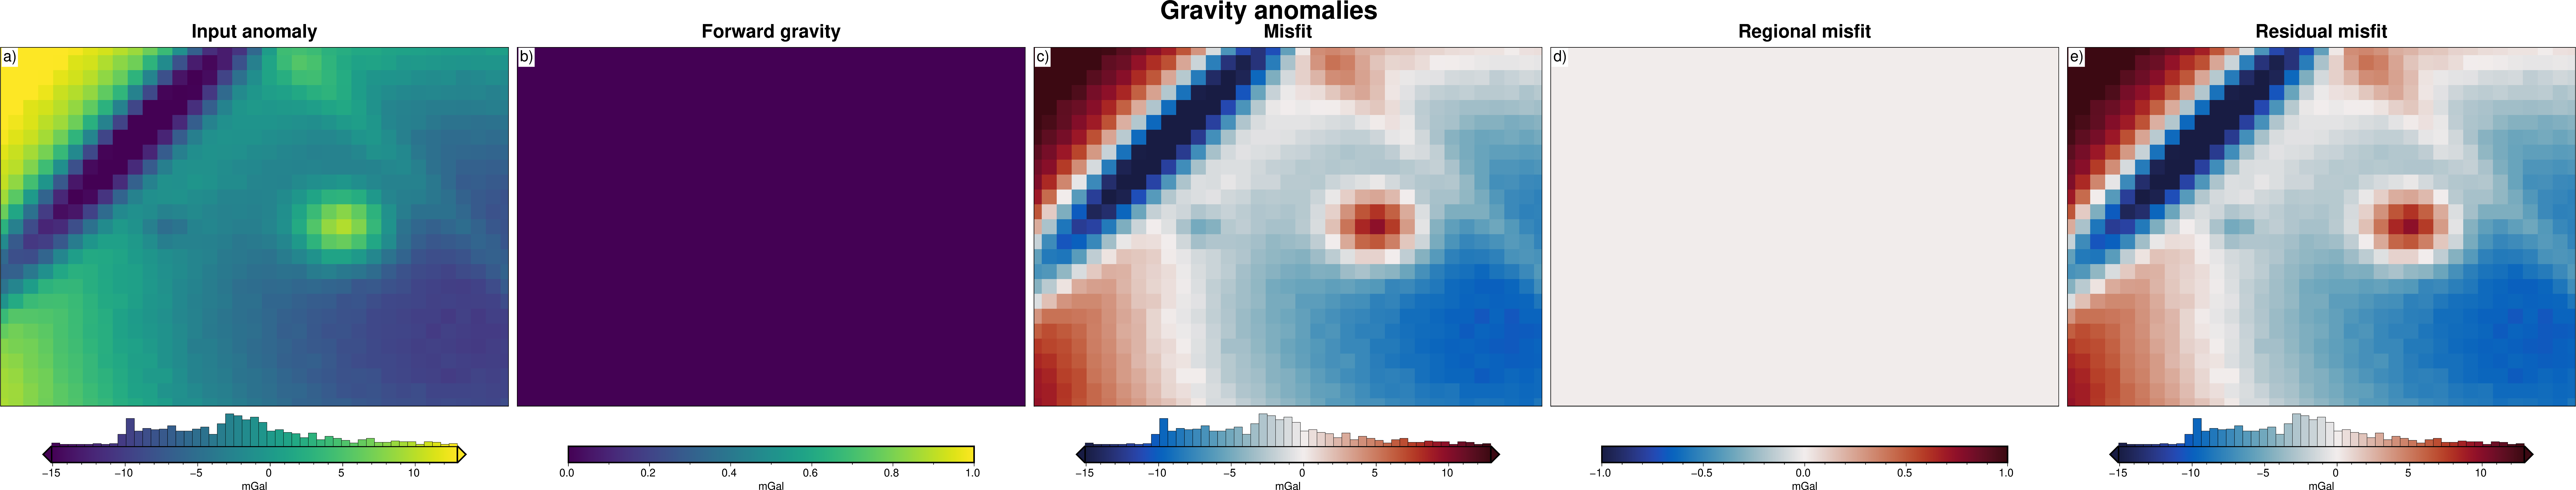

In [9]:
data.inv.plot_anomalies()

## Initialize the Inversion class
The class `inversion.Inversion` holds the `GravData` and `Model` objects, as well as all the parameters of the inversion, such as the stopping criteria, and options for regularization, and how to run the inversion. Some of the options you can set during initialization include:
* `max_iterations`: set to avoid very long running inversions, this should be set high to avoid early termination. 
* `l2_norm_tolerance`: defines when the inversion should end based on the l2-norm of the residual gravity misfit. The l2-norm is the square-root of the root mean squared misfit. 
* `delta_l2_norm_tolerance`: defines when the inversion should end if it is not making any significant progress. A value of 1 means the l2-norm has not changed from the past iteration, while a value of 1.005 means the l2-norm has decreased by ~0.5%.
* `solver_damping`: typically between ~0 and ~1 where high values gives smoother topography.
* `apply_weighting_grid`: a flag to use the optional `weighting_grid` to ensure adhere to constraints`.
  

During the inversion, attributes will be added such as the current iteration, the L2-norm and the computation time. The attributes `GravData` and `Model` will be updated during the inversion to track the gravity and topography during each iteration.

In [10]:
data

<xarray.Dataset> Size: 92kB
Dimensions:          (northing: 31, easting: 41)
Coordinates:
  * northing         (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting          (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    upward           (northing, easting) float64 10kB 1e+03 1e+03 ... 1e+03
    gravity_anomaly  (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
    forward_gravity  (northing, easting) float64 10kB -0.0 -0.0 ... -0.0 -0.0
    misfit           (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
    reg              (northing, easting) int64 10kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    res              (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
    starting_misfit  (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
    starting_reg     (northing, easting) int64 10kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    starting_res     (northing, easting) float64 10kB 9.07 9.813 ... 2.527 2.473
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)

In [15]:
inv = invert4geom.Inversion(
    data,
    model,
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.45,
    delta_l2_norm_tolerance=1.005,
)

## Perform inversion
Now that we have the Inversion object which holds the starting model and residual gravity misfit data we can start the inversion. As the inversion progresses, the attributes `inv.Data` and `inv.Model` will be updated.

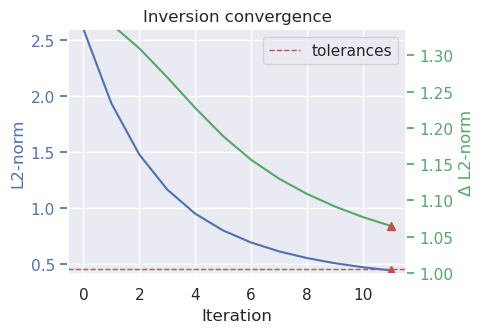

In [16]:
inv.invert(
    plot_dynamic_convergence=True,
)

The above plot shows how the l2-norm and delta l2-norm have been reduced during the inversion. The red line at the bottom marks the set tolerances for each of these. This show that the inversion terminated at the 12 inversion since the l2-norm was lower than the set l2-norm tolerance. 

We can access the statistics of the inversion results with the attribute `stats_df`.

In [17]:
inv.stats_df

,iteration,rmse,l2_norm,delta_l2_norm,iter_time_sec
0,0.0,6.743327,2.596792,inf,NaN
1,1.0,3.738588,1.933543,1.343023,0.316364
2,2.0,2.179115,1.476183,1.309826,0.416374
3,3.0,1.351390,1.162493,1.269842,0.378477
4,4.0,0.896731,0.946959,1.227607,0.382144
5,5.0,0.634698,0.796679,1.188632,0.423225
6,6.0,0.474901,0.689130,1.156065,0.395226
7,7.0,0.371942,0.609870,1.129962,0.345981
8,8.0,0.302468,0.549971,1.108915,0.358454
9,9.0,0.253859,0.503844,1.091549,0.421551


We can see why the inversion terminated with `termination_reason`

In [18]:
inv.termination_reason

['l2-norm tolerance']

We can see the gravity data for each iteration:

In [20]:
inv.data

<xarray.Dataset> Size: 204kB
Dimensions:                   (northing: 31, easting: 41)
Coordinates:
  * northing                  (northing) float64 248B 0.0 1e+03 ... 3e+04
  * easting                   (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
Data variables: (12/20)
    upward                    (northing, easting) float64 10kB 1e+03 ... 1e+03
    gravity_anomaly           (northing, easting) float64 10kB 9.07 ... 2.473
    forward_gravity           (northing, easting) float64 10kB 8.228 ... 2.093
    misfit                    (northing, easting) float64 10kB 9.07 ... 2.473
    reg                       (northing, easting) int64 10kB 0 0 0 0 ... 0 0 0 0
    res                       (northing, easting) float64 10kB 0.842 ... 0.3793
    ...                        ...
    iter_6_initial_residual   (northing, easting) float64 10kB 2.436 ... 0.8784
    iter_7_initial_residual   (northing, easting) float64 10kB 1.983 ... 0.7431
    iter_8_initial_residual   (northing, easting) float64 10kB 1.637 ... 0.6365
    iter_9_initial_residual   (northing, easting) float64 10kB 1.367 ... 0.5515
    iter_10_initial_residual  (northing, easting) float64 10kB 1.153 ... 0.4826
    iter_11_initial_residual  (northing, easting) float64 10kB 0.9815 ... 0.4262
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)

We can see the topography results for each iteration:

In [21]:
inv.model

<xarray.Dataset> Size: 661kB
Dimensions:                (northing: 31, easting: 41)
Coordinates:
    top                    (northing, easting) float64 10kB 620.7 ... 535.2
    bottom                 (northing, easting) float64 10kB 500.0 ... 500.0
  * northing               (northing) float64 248B 0.0 1e+03 ... 2.9e+04 3e+04
  * easting                (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
Data variables: (12/63)
    density                (northing, easting) int64 10kB 2669 2669 ... 2669
    thickness              (northing, easting) float64 10kB 0.0 0.0 ... 0.0 0.0
    starting_topography    (northing, easting) float64 10kB 500.0 ... 500.0
    topography             (northing, easting) float64 10kB 620.7 ... 535.2
    mask                   (northing, easting) float64 10kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
    ...                     ...
    topography_correction  (northing, easting) float64 10kB 2.438 ... 0.9428
    iter_11_top            (northing, easting) float64 10kB 620.7 ... 535.2
    iter_11_bottom         (northing, easting) float64 10kB 500.0 ... 500.0
    iter_11_density        (northing, easting) int64 10kB 2669 2669 ... 2669
    iter_11_layer          (northing, easting) float64 10kB 620.7 ... 535.2
    iter_11_correction     (northing, easting) float64 10kB 2.438 ... 0.9428
Attributes:
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    zref:              500
    density_contrast:  2669
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           1000.0

The final inverted topography can be accessed from the `topography` variable of the prism layer.

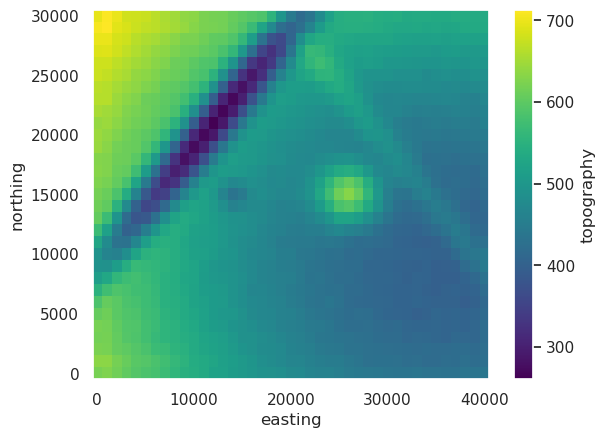

In [22]:
inv.model.topography.plot()

The below three plots show:
1) a comparison of the starting topography (flat) and the final inverted topography
2) a comparison of the residual gravity misfit before and after the inversion
3) the results of 4 of the 12 iterations where the left column shows that iterations starting residual misfit, the middle column shows the current state of the topography, and the right column shows the correction that was applied to the topography during that iteration

In [24]:
model

<xarray.Dataset> Size: 92kB
Dimensions:                (northing: 31, easting: 41)
Coordinates:
  * easting                (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
  * northing               (northing) float64 248B 0.0 1e+03 ... 2.9e+04 3e+04
    top                    (northing, easting) float64 10kB 500.0 ... 500.0
    bottom                 (northing, easting) float64 10kB 500.0 ... 500.0
Data variables:
    density                (northing, easting) int64 10kB 2669 2669 ... 2669
    thickness              (northing, easting) float64 10kB 0.0 0.0 ... 0.0 0.0
    starting_topography    (northing, easting) float64 10kB 500.0 ... 500.0
    topography             (northing, easting) float64 10kB 500.0 ... 500.0
    mask                   (northing, easting) float64 10kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
Attributes:
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    zref:              500
    density_contrast:  2669
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           1000.0

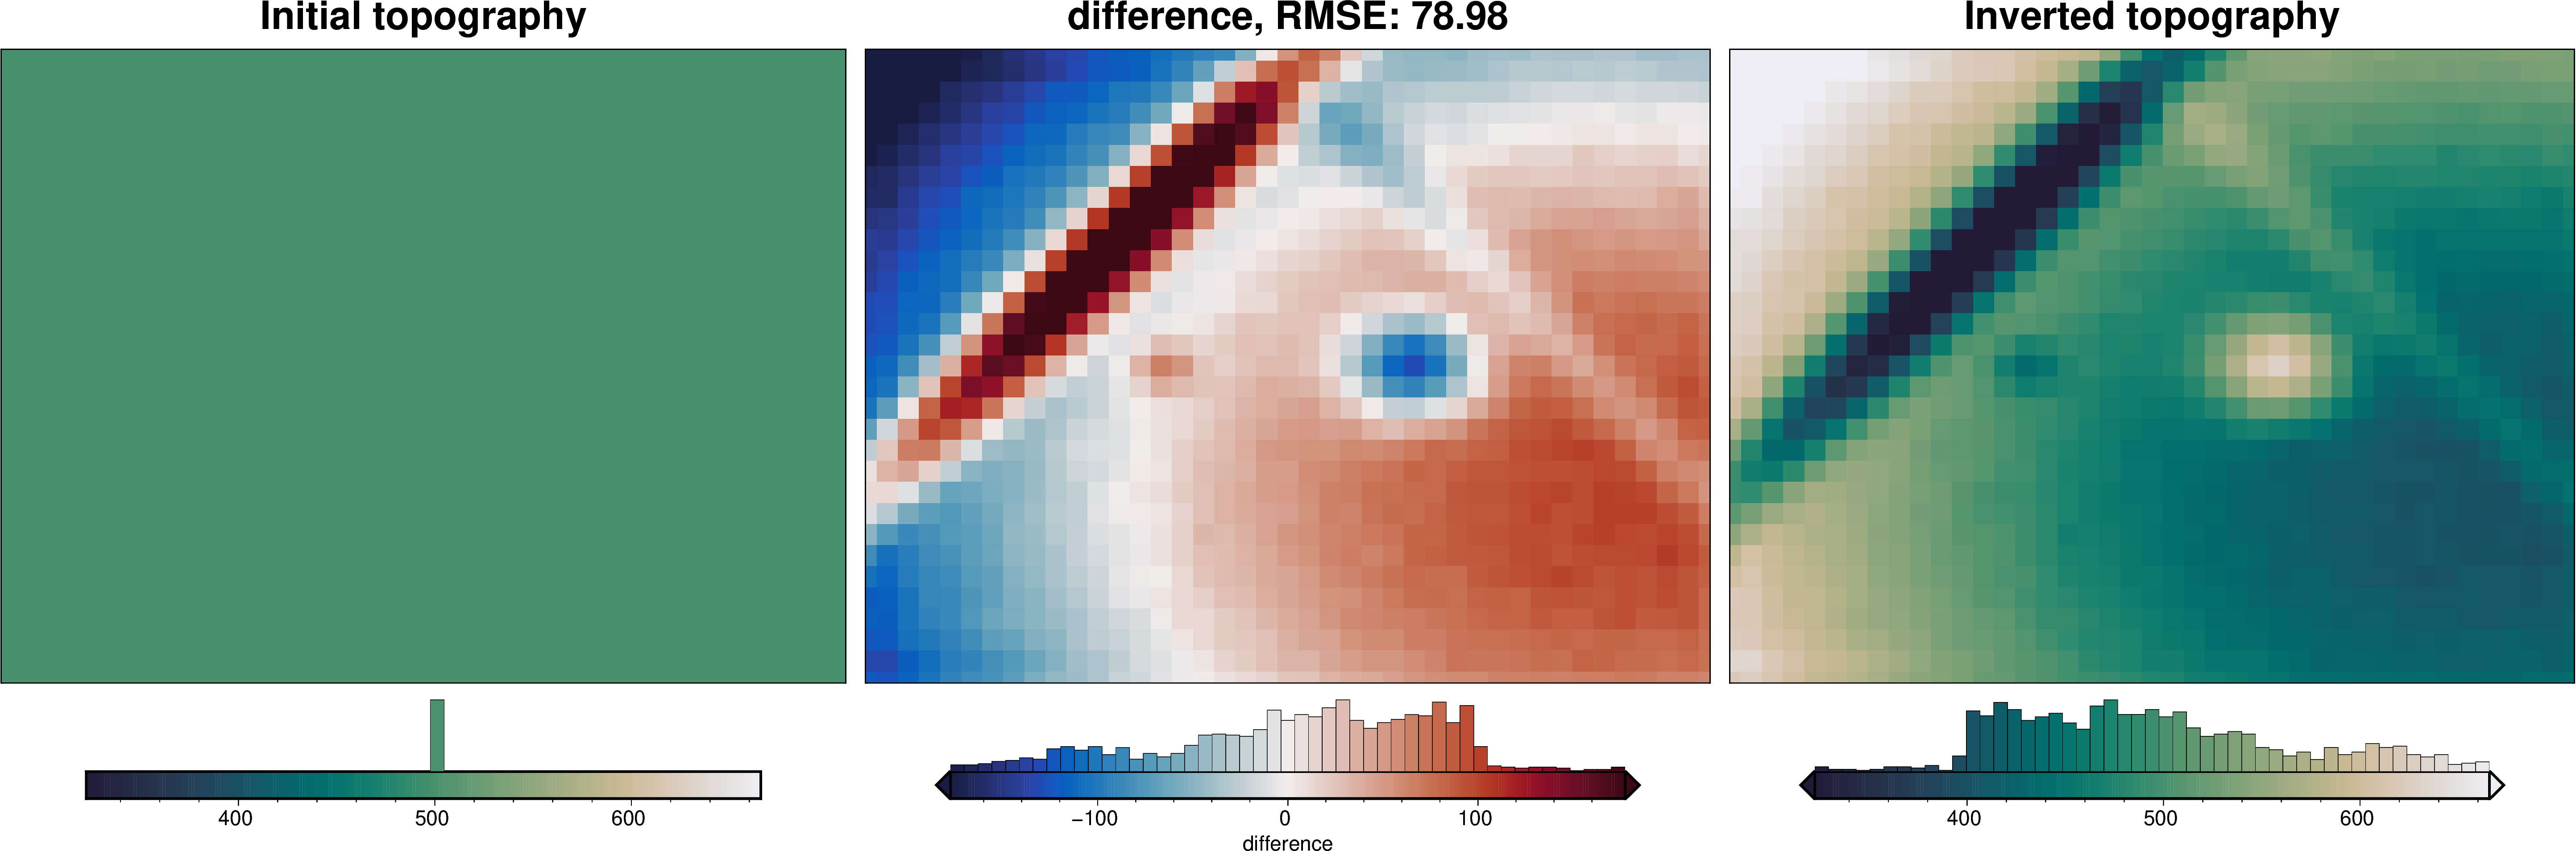

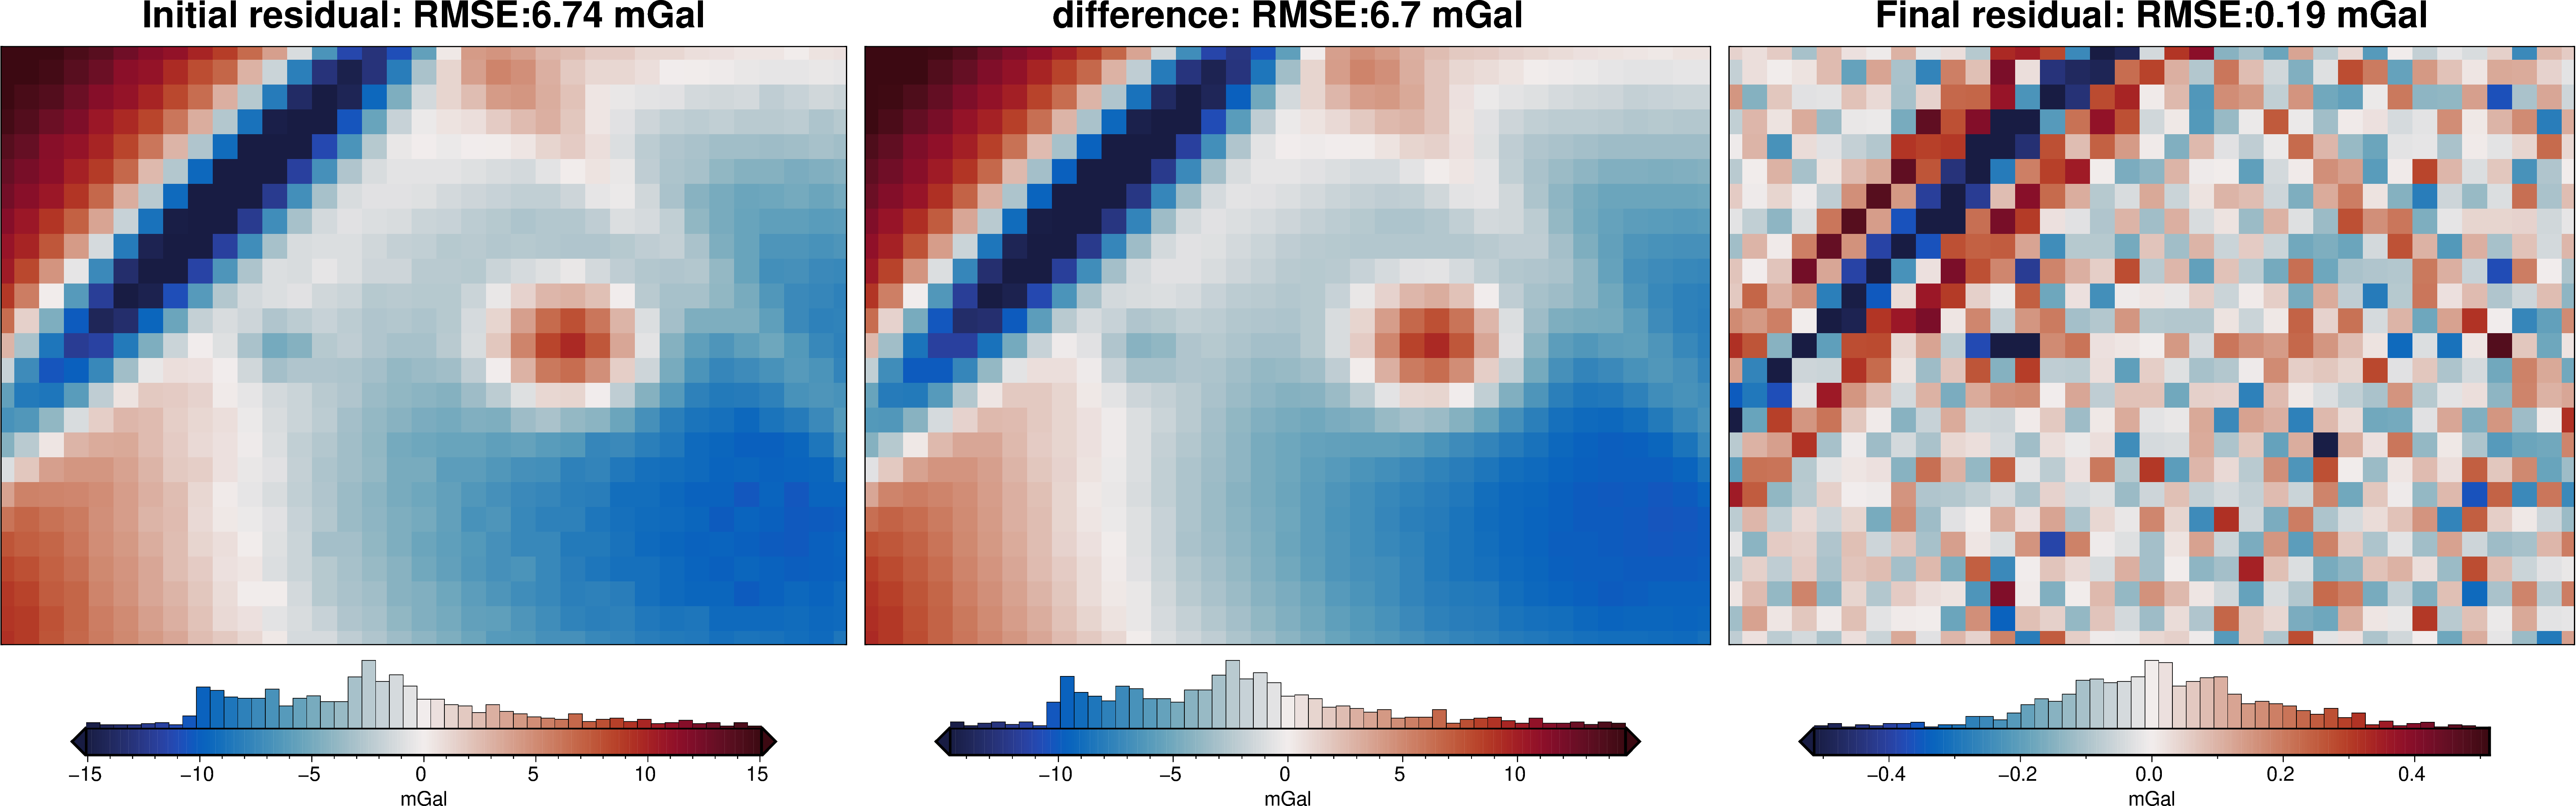

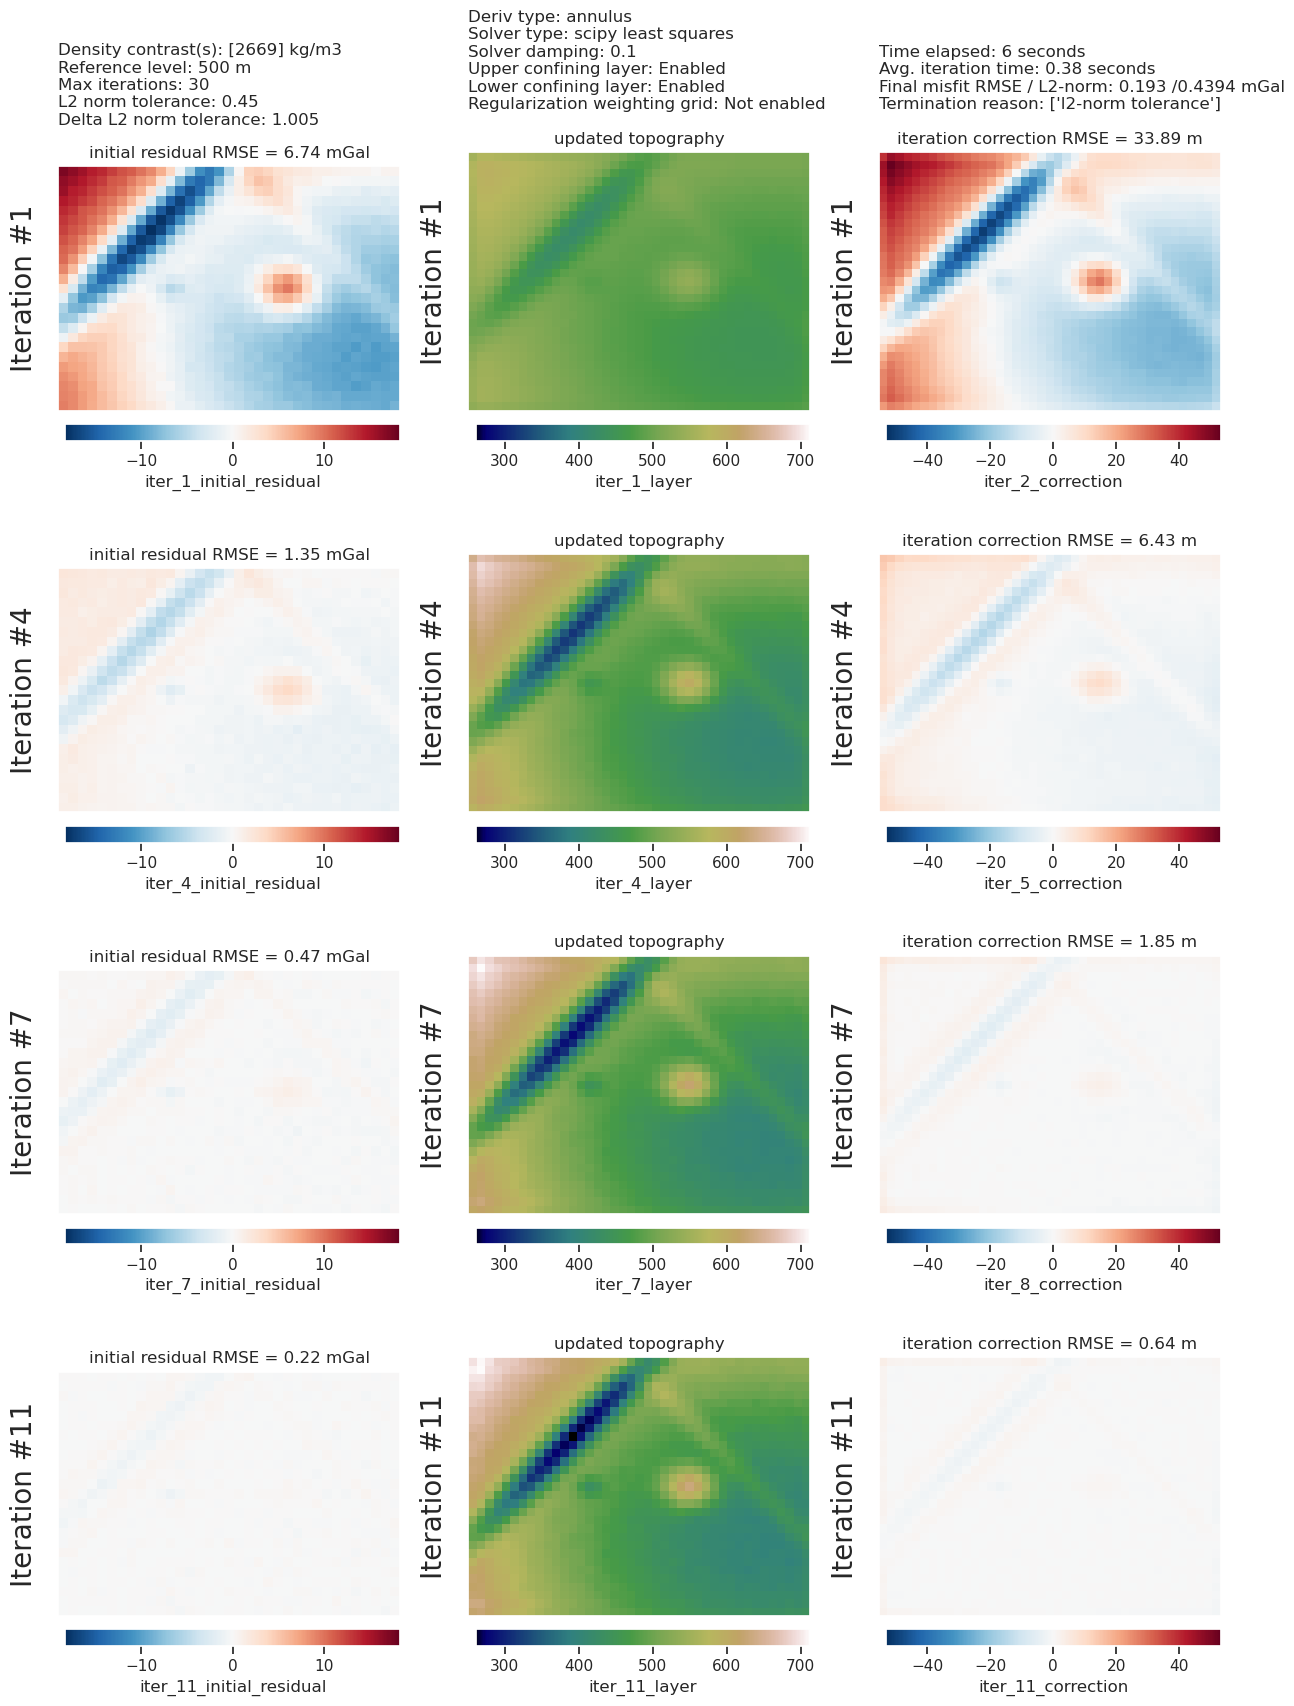

In [25]:
inv.plot_inversion_results(
    iters_to_plot=4,
)

Below we compare the true topography with the results of the inversion to see how it performed. In this example, we assumed we knew the correct density contrast value and zref, and added minimal noise to the observed gravity, so we expect the inversion to accurately recover the true topography.

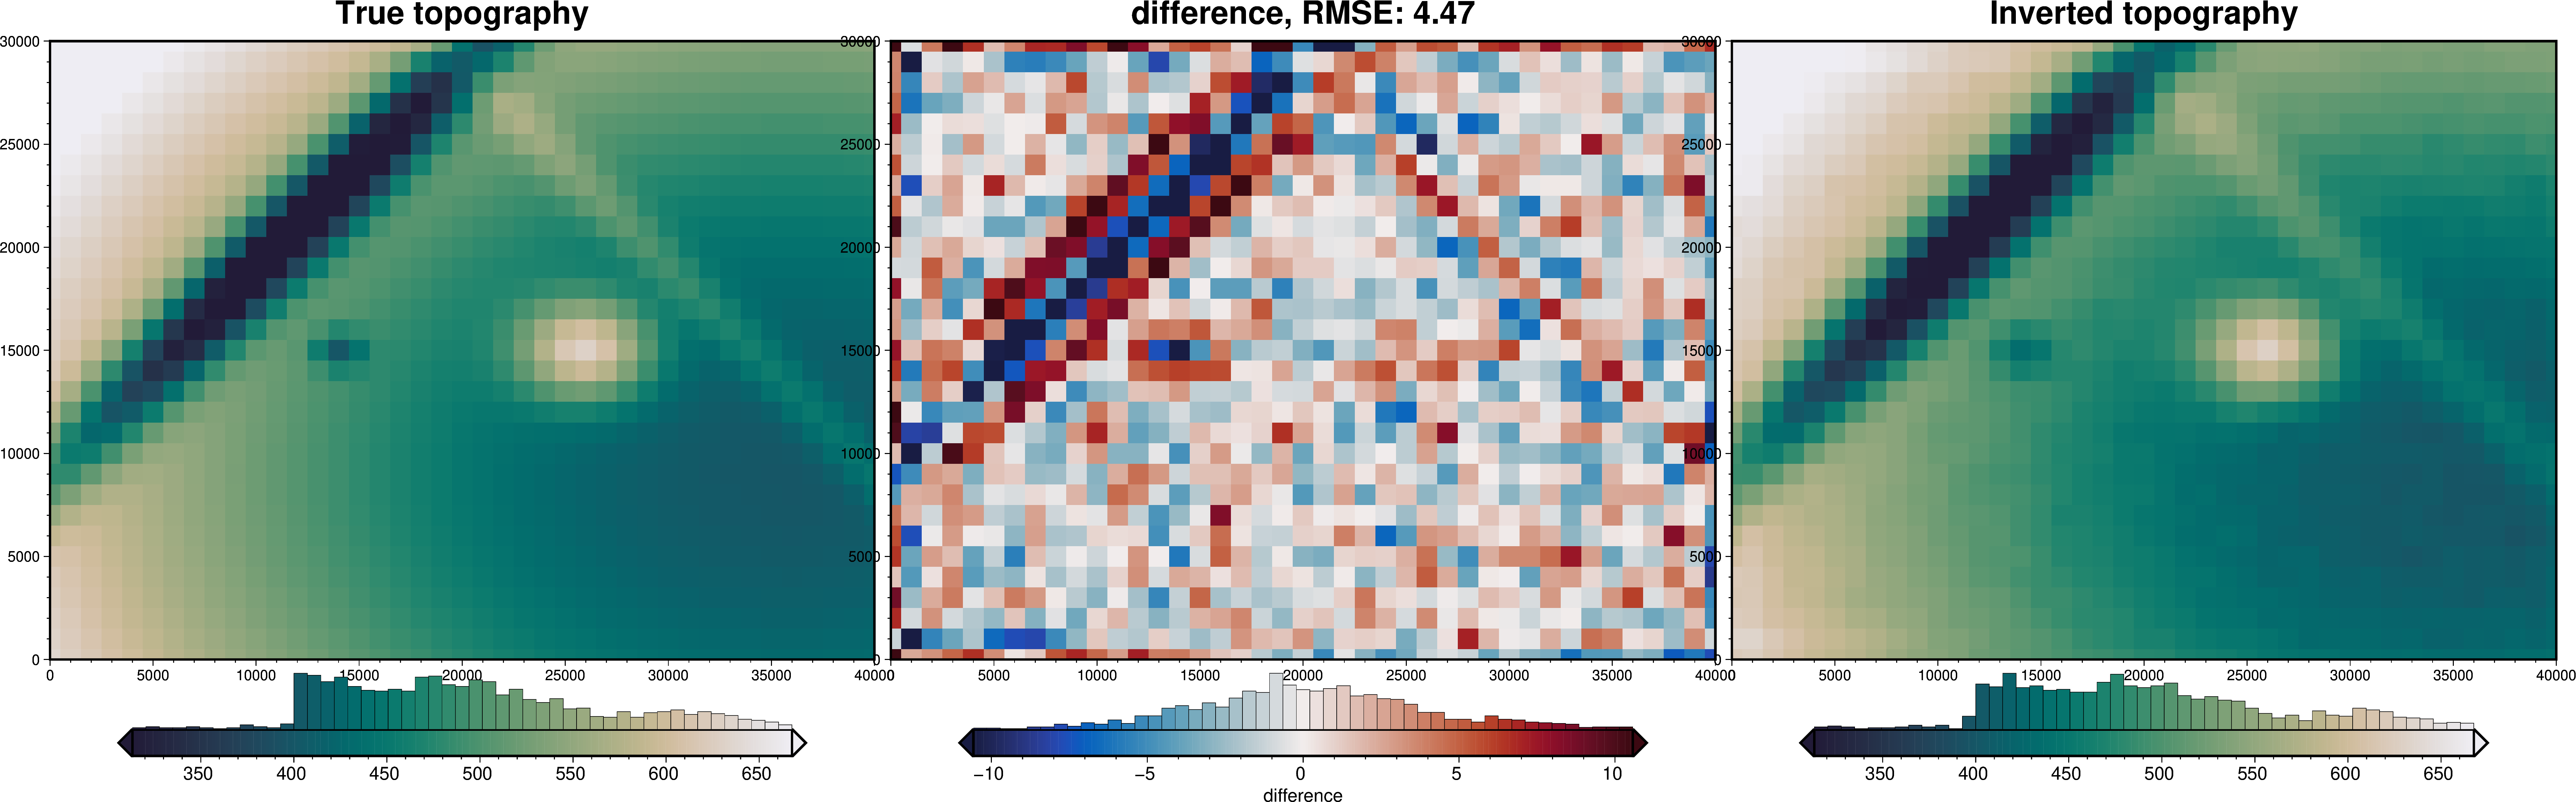

In [26]:
_ = polar_utils.grd_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    frame=True,
)

As you can see, the inversion successfully recovered the true topography. The root mean square difference between the true and recovered topography is low, but this is not too surprising since we gave the inversion the true density contrast and appropriate zref value.

See [05_density_cross_validation.ipynb](05_density_cross_validation.ipynb) and [06_reference_level_cross_validation.ipynb](06_reference_level_cross_validation.ipynb) for examples of how to best choose those values in scenarios where you don't know them.

The notebook, [04_damping_cross_validation.ipynb](04_damping_cross_validation.ipynb) will explain how to use cross validation to choose the optimal damping parameter value. Here, we simply chose an arbitrary value which appeared to work well. With real data with noise, this choice of the damping parameter becomes very important. 